Use tf210-gpu environment

## Preparation

In [23]:
import os
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd

from sklearn.linear_model import RidgeCV, Ridge, LinearRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import gc

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict


In [24]:
model_selections = ['CueBasedLSTM', 'SocialGNN_V', 'CueBasedLSTM-Relation']
layer_selections = ['final_state', 'final_state', 'final_state']
pc_number = 20
output_dim = 2
encoding_method = 'linear_reg' # linear_reg or ridge_reg
model_encoding_dir = f'../layer_representations/PC{pc_number}/'
image_out_dir = f'../result_figures/behavioral_encoding/PC{pc_number}.png'

In [25]:
target_ratings_dir = '../Data/behavioral_ratings.csv'
ratings_of_interest =['spatial expanse', 'object directed','interagent distance', 'agents facing', 'communication',  'joint action', 'valence', 'arousal']

In [26]:
def load_pickle(path):
    with open(path, 'rb') as f:
        pickled = pickle.load(f)
    return pickled

In [27]:
ratings_df = pd.read_csv(target_ratings_dir)[['video_name'] + ratings_of_interest]
ratings_df_sorted = ratings_df.sort_values(by='video_name')

In [28]:
def get_train_test_representations(rep_path):
    layer_representation = np.vstack(load_pickle(rep_path))                
    # Flatten the representation if necessary
    model_representations = layer_representation.reshape(layer_representation.shape[0], -1)
    # print('shape of input', model_representations.shape)
    # Step 1: Create a mapping of video names to their indices
    train_name_idx = load_pickle('../Data/train_idx.pkl')
    test_name_idx = load_pickle('../Data/test_idx.pkl')
    # Step 2: Average the representations for each video
    def average(video_indices):
        averaged_representations = []
        for video, indices in video_indices.items():
            # Extract representations for the current video
            video_reps = model_representations[indices]
            # Compute the average representation
            averaged_rep = np.mean(video_reps, axis=0)
            averaged_representations.append(averaged_rep)
        # Step 3: Convert the list to a numpy array
        averaged_representations = np.array(averaged_representations)  # Shape: (n_videos, n_hidden_dim)
        return averaged_representations
    train_representations = average(train_name_idx)
    test_representations = average(test_name_idx)
    # print('shape of data',train_representations.shape)
    # print('shape of data',test_representations.shape)
    return train_representations, test_representations
    

In [29]:
def get_train_test_targets():
    # Load the data CSV and the train test video names CSV
    data_df = pd.read_csv(target_ratings_dir)[['video_name'] + ratings_of_interest]
    # Extract the list of names
    train_video_names = list(load_pickle('../Data/train_idx.pkl').keys())
    test_video_names = list(load_pickle('../Data/test_idx.pkl').keys())
    # Filter the data to include only rows with video names in the train list
    train_data = data_df[data_df['video_name'].isin(train_video_names)]
    test_data = data_df[data_df['video_name'].isin(test_video_names)]
    # Drop the first column (video name) to retain only numeric values
    train_values = train_data.drop(columns=['video_name']).values
    test_values = test_data.drop(columns=['video_name']).values
    # Convert to a 2D numpy array
    train_values_matrix = np.array(train_values)
    test_values_matrix = np.array(test_values)
    return train_values_matrix, test_values_matrix

## Encoding


In [30]:
# ''' Function for you to test out the encoding results of a single layer from a selected model
#     Input: X - a numpy array of loaded pickle file (n_samples=250, n_features)
#     Example Usage: 
#     model_features = load_pickle('Data/layer_representations/SocialGNN/final_state/GazeDataset_Jun1523_traintest5Jun23_2_0_SocialGNN_V_5_5_12_12_6_2_20_1.0_1.5_0.001_0.01')
#     X = np.vstack(model_features)
# '''
# 
# def single_layer_encoding(X):
#     results = {}
#     for rating in ratings_of_interest:
#         y = ratings_df_sorted[rating].values
#     
#         # Split data
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     
#         # Initialize the Ridge regression model
#         ridge = Ridge(alpha=1.0)
#     
#         # Fit the model on the training data
#         ridge.fit(X_train, y_train)
#     
#         # Predict on the test data
#         y_pred = ridge.predict(X_test)
#     
#         # Calculate Mean Squared Error
#         mse = mean_squared_error(y_test, y_pred)
#         results[rating] = mse
#         print(f'Mean Squared Error for {rating}: {mse}')

In [31]:
from sklearn.preprocessing import StandardScaler


def z_score_normalize(train_data, test_data):
    """
    Normalize train and test data using z-score normalization.
    
    Parameters:
    train_data (np.array): Training data to be normalized
    test_data (np.array): Test data to be normalized using train data parameters
    
    Returns:
    tuple: Normalized train_data and test_data
    """
    if train_data.ndim == 1:
        train_data = train_data.reshape(-1, 1)
        test_data = test_data.reshape(-1, 1)
    scaler = StandardScaler()
    normalized_train_data = scaler.fit_transform(train_data)
    normalized_test_data = scaler.transform(test_data)
    if normalized_train_data.shape[1] == 1:
        normalized_train_data = normalized_train_data.flatten()
        normalized_test_data = normalized_test_data.flatten()
    return normalized_train_data, normalized_test_data

In [32]:
def regression_benchmarking(train_target, test_target, layers, models_classes, method='least square',
                            n_splits=4, random_seed=0, alphas=None):
    if alphas is None:
        alphas = np.logspace(-2, 5, 7)
    
    all_model_results = []
    
    # Iterate over each target rating separately
    for target_idx in tqdm(range(train_target.shape[1])):  # Assuming target is a 2D array
        y_train = train_target[:, target_idx]
        y_test = test_target[:, target_idx]
        for i, model_class in enumerate(models_classes):
            trained_model_path = os.path.join(model_encoding_dir, model_class)
            for model_name in os.listdir(trained_model_path):
                model_path = os.path.join(trained_model_path, model_name, f'{layers[i]}.pkl')
                X_train, X_test = get_train_test_representations(model_path)
                X_train, X_test = z_score_normalize(X_train, X_test)
                y_train, y_test = z_score_normalize(y_train, y_test)
                
                cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
                test_scores = []
                # Perform cross-validation
                for train_idx, val_idx in cv.split(X_train):
                    # Split the data into training and validation sets
                    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

                    if method == 'ridge_reg':
                        model = RidgeCV(alphas=alphas, store_cv_values=True)
                    elif method == 'linear_reg':
                        model = LinearRegression()
                    else:
                        raise ValueError('method must be either ridge_reg or linear_reg')
                        
                    model.fit(X_train_fold, y_train_fold)
                    y_val_pred = model.predict(X_val_fold)
                    # Calculate the Pearson correlation for test set
                    val_score = pearsonr(y_val_fold, y_val_pred)[0]
                    test_scores.append(val_score)
                    
                mean_test_score = np.mean(test_scores)
                
                # # Predict on the test set using the final model (fit on the whole training data)
                # model.fit(X_train, y_train)
                # y_test_pred = model.predict(X_test)
                # 
                # # Calculate the Pearson correlation for the test set
                # test_score = pearsonr(y_test, y_test_pred)[0]
    
                # Store results for this target
                all_model_results.append({
                    'feature': ratings_of_interest[target_idx],
                    'test_score': mean_test_score,
                    'layer': layers[i],
                    'model_name': model_name,
                    'model_class': model_class
                })

                # Memory cleanup
                gc.collect()


    return pd.DataFrame(all_model_results)


In [33]:
train_target, test_target = get_train_test_targets()

In [34]:
# ridge_results = regression_benchmarking(target, layer_selections, model_selections, method = 'ridge_reg')
linear_results = regression_benchmarking(train_target, test_target, layer_selections, model_selections, method = 'linear_reg')

100%|██████████| 8/8 [00:53<00:00,  6.63s/it]


In [35]:
x_labels = ['spatial expanse', 'object directed', 'interagent distance', 'agents facing', 'communicating', 'acting jointly', 'valence', 'arousal']


# Assuming 'results_df' is the DataFrame returned by regression_benchmarking function
def plot_mapping_results(results_df, out_dir, size=(10, 5), dodge=0.55):
    _, ax = plt.subplots(figsize=size)
    sns.stripplot(x='feature', y='test_score', hue='model_class', data=results_df,
                  ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
    strip_collections = ax.collections
    sns.pointplot(x='feature', y='test_score', hue='model_class', data=results_df,
                   dodge=dodge, linestyle="none", errorbar=('ci', 95),
                  marker="_", markersize=14, markeredgewidth=3, zorder=1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    ax.set_xticks(ticks)
    ax.set_xticklabels(x_labels, rotation=25, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Score ($r$)')
    ax.set_ylim([-0.25, 1])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              ncol=1, fancybox=True)
    plt.tight_layout()
    plt.savefig(out_dir)
    plt.show()

In [36]:
# plot_mapping_results(ridge_results)

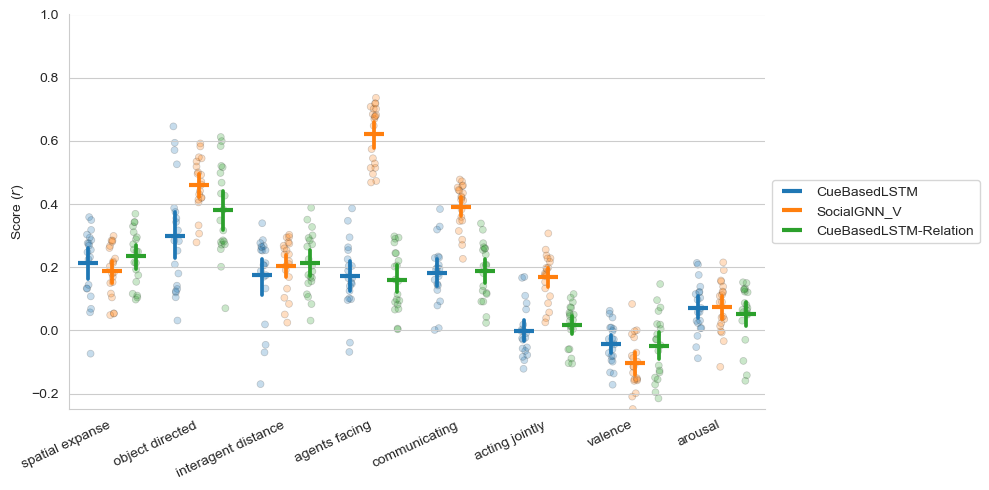

In [37]:
plot_mapping_results(linear_results, image_out_dir)

## Only edge

In [38]:
model_selections = ['LSTM_only_edge', 
                    f'SocialGNN_randomize_node_PC{pc_number}', 
                    f'SocialGNN_zero_node_PC{pc_number}']

layer_selections = ['final_state', 'final_state', 'final_state']

model_encoding_dir = f'../layer_representations/only_edge_models/'
image_out_dir = f'../result_figures/behavioral_encoding/PC{pc_number}_only_edge.png'

In [39]:
only_edge_linear_results = regression_benchmarking(train_target, test_target, layer_selections, model_selections, method = 'linear_reg')

100%|██████████| 8/8 [00:53<00:00,  6.69s/it]


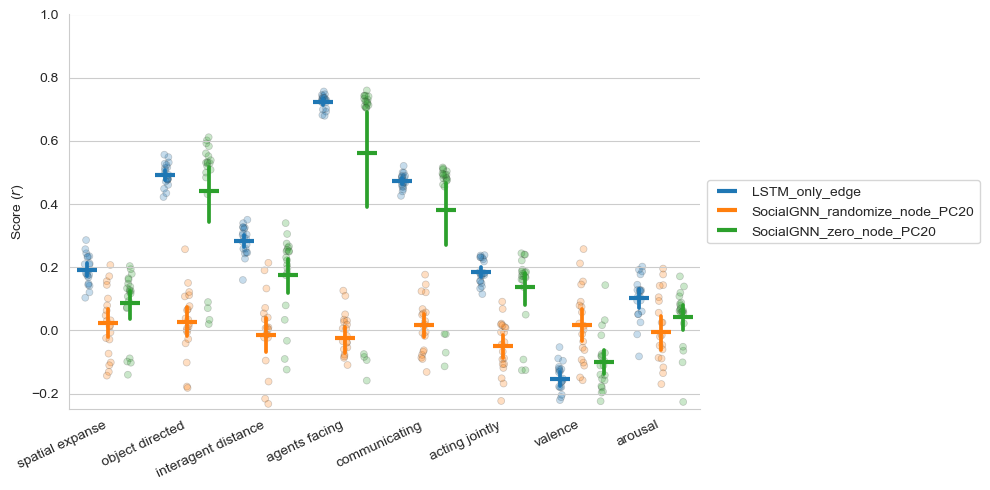

In [40]:
plot_mapping_results(only_edge_linear_results, image_out_dir)

In [41]:
results_concated = pd.concat([linear_results, only_edge_linear_results], axis=0, ignore_index=True)

In [42]:
image_out_dir = f'../result_figures/behavioral_encoding/PC{pc_number}_all_models.png'

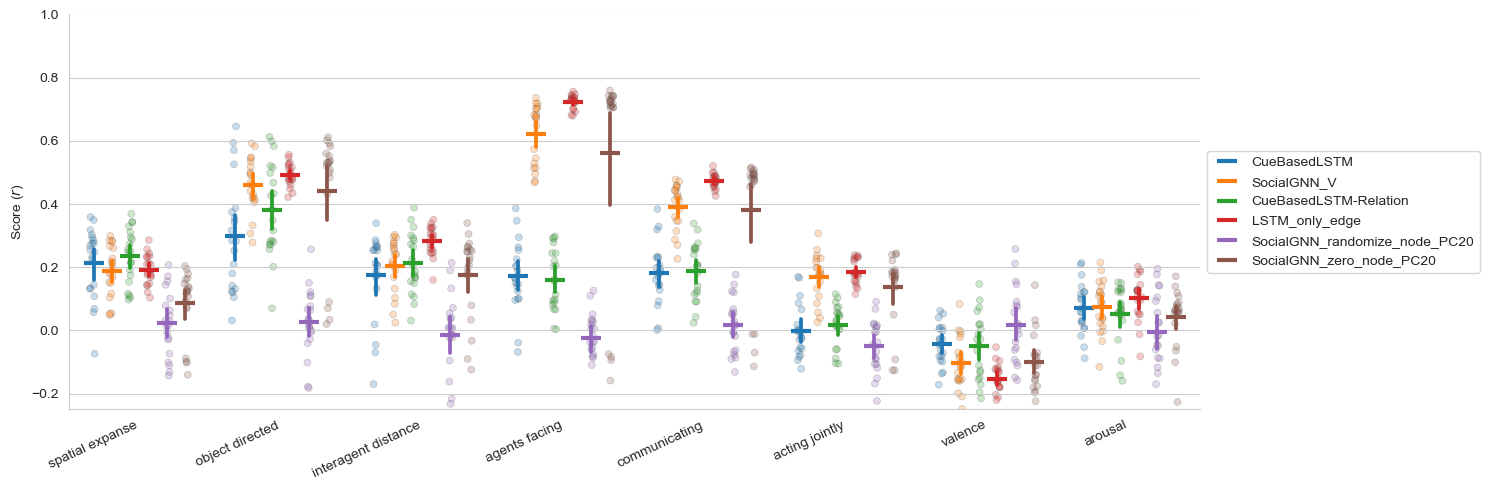

In [43]:
plot_mapping_results(results_concated, image_out_dir, size=(15,5), dodge=0.65)